
# 1D Forward Simulation for a Single Sounding of Permafrost layers

**Based on:** module from *simpeg.electromangetics.frequency_domain_1d* to predict
airborne frequency domain data for a single sounding over a 1D layered Earth.

**Survey:** Forward simulation to mimic the permafrost structure of the AEM survey conducted in August, 2024, by Xcalibur Multiphysic. In the Inuvik-Tuktoyaktuk-Highway (ITH) project. Magnetic dipole at 35 m above the Earth's surface. The receiver is offset\
10 m horizontally from the source.

## Import Modules




In [3]:
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from discretize import TensorMesh

from simpeg import maps
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg.utils import plot_1d_layer_model

plt.rcParams.update({"font.size": 16})
write_output = False


## Create Survey Design

Based on RESOLVE 6 system flew by by Xcalibur Multiphysic in August 2024. Nominal frequencies 135 kHz, 40 kHz, 8.2 kHz, 1.8 kHz and 400 Hz. The flight-line spacing was 100 m, and the average terrain clearance was 35 m for the RESOLVE bird.  




In [5]:
# Frequencies being observed in Hz, same as real survey in ITH
frequencies = np.array([400, 1800, 8200, 40000, 135000], dtype=float)


# Define a list of receivers. The real and imaginary components are defined
# as separate receivers.
receiver_location = np.array([10.0, 0.0, 35.0])
receiver_orientation = "z"  # "x", "y" or "z"
data_type = "ppm"  # "secondary", "total" or "ppm"

receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="imag",
    )
)

# Define the source list. A source must be defined for each frequency.
source_location = np.array([0.0, 0.0, 35.0])
source_orientation = "z"  # "x", "y" or "z"
moment = 1.0  # dipole moment

source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation=source_orientation,
            moment=moment,
        )
    )

# Define a 1D FDEM survey
survey = fdem.survey.Survey(source_list)

## Defining a 1D Layered Earth Model - Permafrost Interpretation

Defined layer thicknesses and electrical conductivities for a simple 1D simulation intended to approximate permafrost stratigraphy based on the ITH project. The model assumes the bottom layer extends to infinity, and includes the following defined layers:

* **Thawing layer**: A seasonally variable active layer near the surface ($\approx$1 m thick), with high conductivity due to moisture content ($\approx$0.1 S/m).  
* **Ice-rich layer**: Dominated by frozen soil and ice blocks ($\approx$25 m thick), highly resistive ($\approx$0.001 S/m).  
* **Transition layer – sand deposits**: A partially thawed, sandy zone ($\approx$15 m thick) with moderate conductivity ($\approx$0.01 S/m).  
* **Older alluvial deposits**: Deeper, likely saturated sediments ($\approx$50 m thick), exhibiting higher conductivity ($\approx$0.1 S/m).


In [7]:
# Physical properties

#Background conductivity
background_conductivity = 0.05

#Seeting layer physical properties

# Thawing layer
layer_conductivity_0 = 0.1

# Ice rich terrain
layer_conductivity_1 = 0.001

# Thawing transition layer - sand deposits
layer_conductivity_2 = 0.01

# Older alluvial deposits
layer_conductivity_3 = 0.1

# Layer thicknesses

# Thawing layer - around 1m
layer_thickness_0 = 1

# Ice rich terrain - around 25 m
layer_thickness_1 = 25

# Thawing transition layer - sand deposits - around 15 m
layer_thickness_2 = 15

# Older alluvial deposits - around 50m
layer_thickness_3 = 50

#bacjkground thickness:
background_thickness = 10


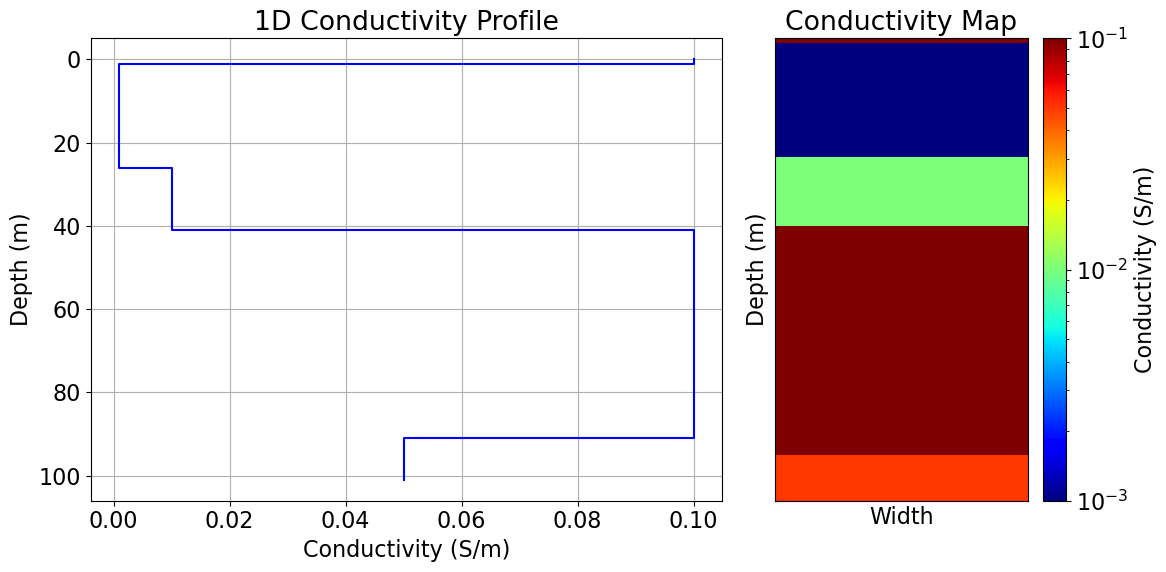

In [8]:
# Build single column vector
depths = [
    (layer_conductivity_0, layer_thickness_0),
    (layer_conductivity_1, layer_thickness_1),
    (layer_conductivity_2, layer_thickness_2),
    (layer_conductivity_3, layer_thickness_3),
    (background_conductivity, background_thickness)
]

# Matrix for plotting
n_cols = 50
m_rows = []

#loop assigning conductivity
for conductivity, thickness in depths:
    m_rows.extend([np.ones(n_cols) * conductivity] * thickness)

m = np.vstack(m_rows)

#STepped profile for plooting
thicknesses = np.array([t[1] for t in depths])
model = np.array([t[0] for t in depths])

layer_tops = np.r_[0.0, np.cumsum(thicknesses)]
layer_bottoms = np.r_[layer_tops[1:], layer_tops[-1] + background_thickness]

# Create the stepped profile data
depths_stepped = []
values_stepped = []
for i in range(len(model)):
    depths_stepped += [layer_tops[i], layer_bottoms[i]]
    values_stepped += [model[i], model[i]]

#Plotting the profile and matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[2, 1])

# 1. Stepped profile plot
ax1.plot(values_stepped, depths_stepped, drawstyle='steps-post', color='blue')
ax1.invert_yaxis()
ax1.set_xlabel("Conductivity (S/m)")
ax1.set_ylabel("Depth (m)")
ax1.set_title("1D Conductivity Profile")
ax1.grid(True)

# 2. Color strip plot
cmap = 'jet'
norm = mcolors.LogNorm(vmin=m.min(), vmax=m.max())
im = ax2.imshow(m, cmap=cmap, norm=norm, aspect='auto', origin='upper')

ax2.set_title("Conductivity Map")
ax2.set_xlabel("Width")
ax2.set_ylabel("Depth (m)")
ax2.set_xticks([])  # Hide x ticks for cleaner look
ax2.set_yticks([])  # Hide y ticks for cleaner look

# Colorbar for the color strip
plt.colorbar(im, ax=ax2, label="Conductivity (S/m)")

# Layout adjustment for a neat figure
plt.tight_layout()
plt.show()

In [9]:
#Not used the last thickness for simulation
thicknesses = thicknesses[:-1]

# Define a mapping from model parameters to conductivities

n_layer = len(thicknesses) +1
model_mapping = maps.IdentityMap(nP=n_layer)


## Define the Forward Simulation, Predict Data and Plot

Simulation and predict the 1D FDEM sounding data by the defined the survey, the layer thicknesses
and a mapping from the model to the conductivities of the layers.

**Noise is added**


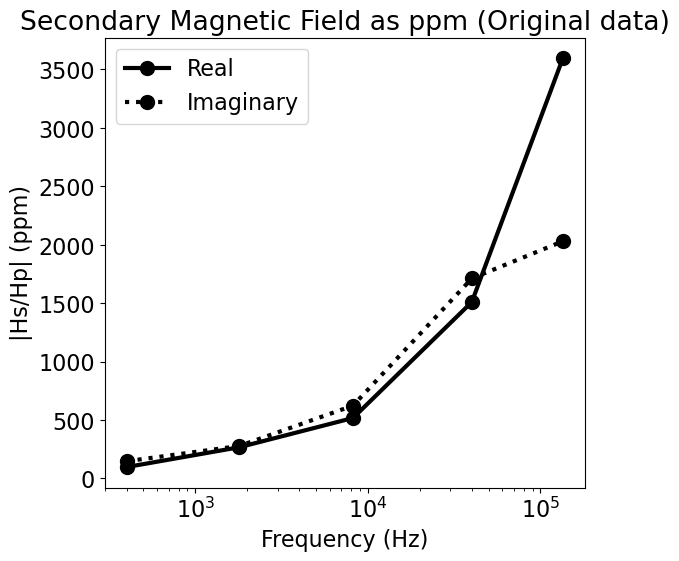

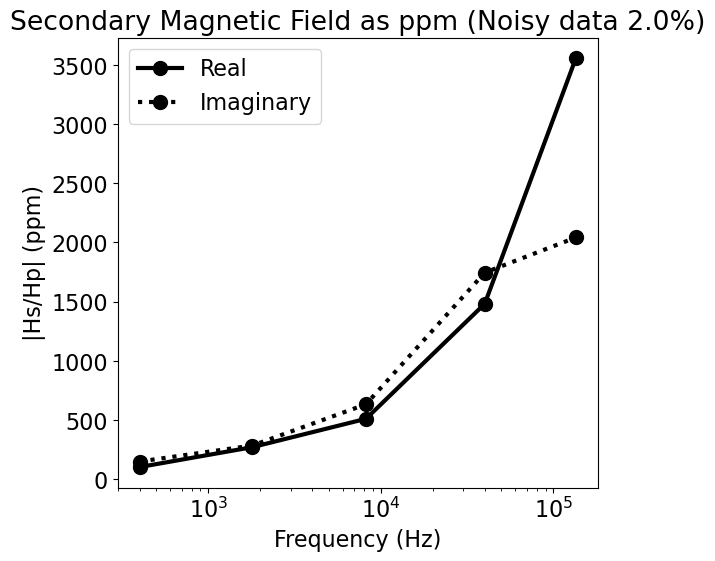

In [11]:
# Define the simulation
simulation = fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
)

# Predict sounding data
dpred = simulation.dpred(model)

# Plot sounding data
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.semilogx(frequencies, np.abs(dpred[0::2]), "k-o", lw=3, ms=10)
ax.semilogx(frequencies, np.abs(dpred[1::2]), "k:o", lw=3, ms=10)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title("Secondary Magnetic Field as ppm (Original data)")
ax.legend(["Real", "Imaginary"])

# Add noise to prediction
np.random.seed(222)
noise_level = 0.02
dpred += noise_level * np.abs(dpred) * np.random.randn(len(dpred))

# Plot sounding data
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.semilogx(frequencies, np.abs(dpred[0::2]), "k-o", lw=3, ms=10)
ax.semilogx(frequencies, np.abs(dpred[1::2]), "k:o", lw=3, ms=10)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title(f"Secondary Magnetic Field as ppm (Noisy data {noise_level*100}%)")
ax.legend(["Real", "Imaginary"])

## Optional: Export Data

Export the estimated data with added noise. Saved in outputs folder, same directory. There is a bug on how this is saved, not like is open


In [13]:
#Set to True if want to save the data
write_output = True

if write_output:
    # Create output directory relative to current working dir
    output_dir = "outputs"
    os.makedirs(output_dir, exist_ok=True)

    # Save to file
    fname = os.path.join(output_dir, "em1dfm_data.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, dpred[0::2], dpred[1::2]],
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG"
    )

    print(f"Saved data to: {fname}")

Saved data to: outputs/em1dfm_data.txt
